~~So, to be totally honest. I have no good reason to do this. I just want to practice **web-scraping**. So I thought I'd scrape the DND wiki to see if I can get the spells from the wiki and just see if we can compare what spells can be shared across classes.~~

So this did start as just a web-scraper but... why stop there? This can be for web-scraping **and** for NLP! So:
1. Can we scrape some info together about the spells that we have in DND.
2. Can we use NLP to find out some sentiment analysis, see if we can build up a classifier.

*We are going to ignore sub-classes and any feats which lets you pull from other spell lists as the list is already extensive and painful as it is*

# 0. Imports and Prerequisites
Let's import what we need to use and set up some key parameters for us to make our quality of life run a bit better

In [1]:
random_code = 42
# Used so we can recreate our results.

In [2]:
# Web Scraping Imports
import requests
from bs4 import BeautifulSoup

# Visualisations Imports
import matplotlib.pyplot as plt
import seaborn as sns

# Etc imports
from collections import Counter, defaultdict
import csv

# Machine Learning Imports
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb


In [3]:
# Commented out, download. Run as appropriate.
"""import nltk
nltk.download()"""

'import nltk\nnltk.download()'

In [4]:
# NLP Imports
import re
import nltk.classify.util
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [5]:
exclude = ["discord"]  # Any words we just want to avoid
url = 'https://dnd5e.wikidot.com/'  # Site to scrape

In [6]:
r = requests.get(url)
# Parsing the HTML
soup = BeautifulSoup(r.content, 'html.parser')

# 1. Scraping
We'll start with just picking up on this website and finding what we want.
## 1.1 Top Level Website
The URL above takes us to the front webpage, so we'll see what we can gleam from this.

In [7]:
s = soup.find('div', class_='entry-content')
content = soup.find_all('p')

temp_dict = {}  # We're going to store all the links in a dictionary.
for idx, line in enumerate(content):
    data = line.find_all('a')
    if len(data) > 0: # Ignore all empty lines
        sub_dict = {}  # Our dictionary will be made of sub-dictionaries, just handy for storing the info
        dict_title = None
        for entry in data:
            # This is where we'll exclude our stuff and extract our information
            if not any(excluded in entry.text.lower() for excluded in exclude):
                dict_title = entry.get('href').split(':')[0].split('/')[1]
                sub_dict[entry.text] = entry.get('href')
        
        if dict_title is not None:
            if dict_title in list(temp_dict.keys()):
                temp_dict[dict_title].update(sub_dict)
            else:
                temp_dict[dict_title] = sub_dict

## 1.2 Spells Scraping
Now I want to actually build a list of the spells. 

In [8]:
spell_group = {}
spell_page = {}
spells_dict = temp_dict['spells']
for spells in spells_dict.keys():
    link = url + spells_dict[spells]
    r = requests.get(link)
    # Parsing the HTML
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('div', class_='entry-content')
    content = soup.find_all('td')
    # Initialise some key points that we'll use to record our for-loop
    spell_info = {}
    spell_name = None
    spell_contents = []
    for idx, line in enumerate(content): # Loop through each line of the table.
        if idx%6 == 0:
            if idx != 0:  # If this is the first entry, we'll initialise the dictionary
                spell_info[spell_name] = spell_contents
            spell_name = line.text
            spell_contents = []
            entry = line.find_all('a') # Now this is used for us to get the links for our new page!
            if len(entry) > 0:
                spell_page[spell_name] = entry[0].get('href')
        else:
            spell_contents.append(line.text)
    spell_group[spells] = spell_info

In [9]:
class_spell_group = {key: value for key, value in spell_group.items() if "Spell" in key}  # This will only group spells by class now.

# 2. Crude Analysis
Now let's see what fun info we can get from this!
## 2.1 Number of Spells
First, let's see how many spells are shared by different classes.

Artificer Spells - Number of Spells: 102
Bard Spells - Number of Spells: 168
Cleric Spells - Number of Spells: 129
Druid Spells - Number of Spells: 175
Paladin Spells - Number of Spells: 53
Ranger Spells - Number of Spells: 75
Sorcerer Spells - Number of Spells: 265
Warlock Spells - Number of Spells: 170
Wizard Spells - Number of Spells: 408


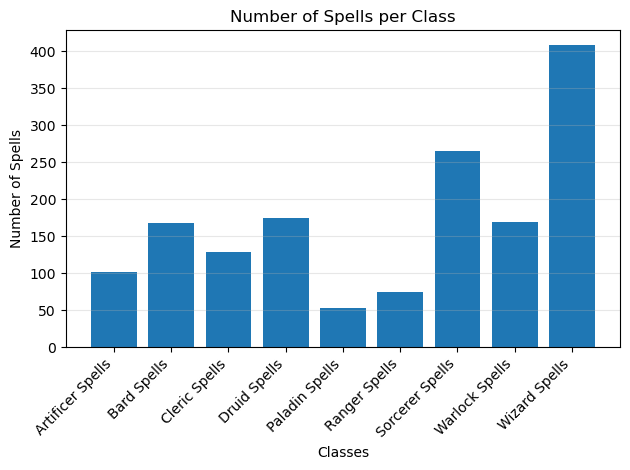

In [10]:
n_spells = []
for classes in class_spell_group:
    n =  len(class_spell_group[classes])
    n_spells.append(n)
    print(classes, "- Number of Spells:", n)

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), n_spells)
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right") 
plt.tight_layout() 
plt.show()

In [11]:
spell_to_classes = defaultdict(list)
class_to_spells = defaultdict(list)

for classes, spells in class_spell_group.items():
    for spell in spells:
        spell_to_classes[spell].append(classes)

spells_by_class = {spell: classes for spell, classes in spell_to_classes.items()}
spells_in_multiple_classes = {spell: classes for spell, classes in spell_to_classes.items() if len(classes) > 1}

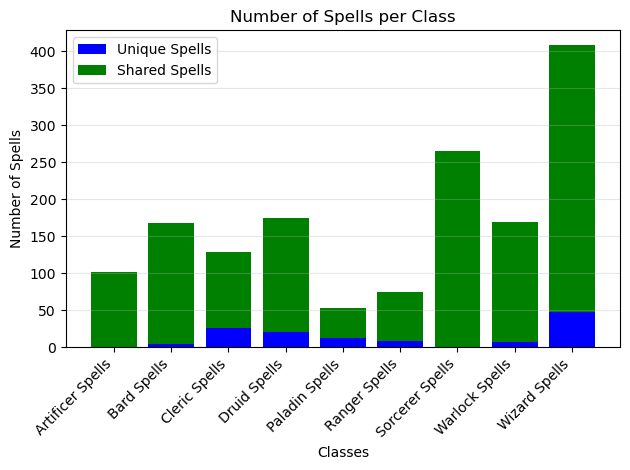

In [12]:
shared_spell_counts = defaultdict(int)

for spell, classes in spells_in_multiple_classes.items():
    for class_name in classes:
        shared_spell_counts[class_name] += 1

classes = list(shared_spell_counts.keys())
shared_counts = list(shared_spell_counts.values())

classes, shared_counts = zip(*sorted(zip(classes, shared_counts)))

total_counts = [len(class_spell_group[class_name]) for class_name in class_spell_group.keys()]
shared_counts = [shared_spell_counts.get(class_name, 0) for class_name in class_spell_group.keys()]
unique_counts = [total - shared for total, shared in zip(total_counts, shared_counts)]

plt.grid(alpha=0.3, axis='y')
plt.bar(class_spell_group.keys(), unique_counts, color='blue', label='Unique Spells')
plt.bar(class_spell_group.keys(), shared_counts, bottom=unique_counts, color='green', label='Shared Spells')
plt.xlabel("Classes")
plt.ylabel("Number of Spells")
plt.title("Number of Spells per Class")
plt.xticks(rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Oh and for any DND buffs. I'm counting "Cantrips" as spells. I'm not messing about with the whole *"Well they're not **Technically** spells"*, they are and I won't hear otherwise.

In [13]:
for n_classes in range(len(class_spell_group.keys()),1,-1):    
    shared_spells = {spell: classes for spell, classes in spells_in_multiple_classes.items() if len(classes) == n_classes}

    print(f"\nNumber of spells shared amongst {n_classes} classes: {len(shared_spells)}")
    print(f"Spell(s) shared amongst ({n_classes} classes):")
    """for spell, classes in shared_spells.items():
        print(f"{spell}: {', '.join(classes)}")"""


Number of spells shared amongst 9 classes: 0
Spell(s) shared amongst (9 classes):

Number of spells shared amongst 8 classes: 2
Spell(s) shared amongst (8 classes):

Number of spells shared amongst 7 classes: 1
Spell(s) shared amongst (7 classes):

Number of spells shared amongst 6 classes: 8
Spell(s) shared amongst (6 classes):

Number of spells shared amongst 5 classes: 36
Spell(s) shared amongst (5 classes):

Number of spells shared amongst 4 classes: 97
Spell(s) shared amongst (4 classes):

Number of spells shared amongst 3 classes: 167
Spell(s) shared amongst (3 classes):

Number of spells shared amongst 2 classes: 138
Spell(s) shared amongst (2 classes):


# 3.0 Natural Language Processing (NLP), Sentiment Analysis and Label Predictor
Okay, so the initial conception of this (*We'll see how this stays as I continue to do this analysis*) is that each of the DND Wiki spell page provides a description of what the spell does. Ultimately, these spells can will provide a lot of information to the reader about what it does.

The original idea was that I would capture these into the following classifications:
1. Damage Dealer (e.g, acid splash does 1d6 damage)
2. Ability Modifier (e.g., guidance provides 1d4 to a skill check)
3. Healing (e.g., healing word does 1d4 hp)
4. Other (e.g., prestidigitation)

But then I realised I would have to label these myself and that just isn't very fun.

**BUT** then I realised, there is already a key inbuilt classification:
1. Conjuration
2. Necromancy
3. Evocation
*So forth so forth*

They have been labelled for me already. Look, this is just practice where I'm apply some skills!
## 3.1 Preprocessing 
Let's tidy up the data and put it in a tidy format for us to utilise

In [14]:
spells_descriptions = {}
spell_classifications = {}
all_words = []

for idx, spells in enumerate(spell_page.keys()):
    link = url + spell_page[spells]
    r = requests.get(link)
    # Parsing the HTML
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('div', class_='entry-content')
    content = soup.find_all('p')
    spell_classifications[spells] = content[1].text
    spells_descriptions[spells] = content[3].text
    """if idx == 5:  # This will run forever, and if there are at least 400 spells, with about a half a second per spell to run this for loop, you have like 4 minutes of waiting.
        break"""
    all_words.append(spells_descriptions[spells])
all_words = ''.join(all_words)

In [15]:
def word_net_delve(token):
    token_net = wordnet.synsets(token)
    token_list = []
    if len(token_net) > 0:
        for aug_token in token_net:
            for lemms in aug_token.lemmas():
                token_list.append(lemms.name())
        return token_list
    else:
        return None

In [16]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
token_all_words = tokenizer.tokenize(all_words)
fd = FreqDist(token_all_words)
#least_common_words = [word_net_delve(word) for word, count in fd.most_common() if count < 4]
#least_common_words = [word for word in least_common_words if word is not None]
#least_common_words = list(itertools.chain.from_iterable(least_common_words))
#most_common_words = [word for word, count in fd.most_common() if count > len(fd.most_common())/10]

In [17]:
classification_categories = ["abjuration", "conjuration", "divination", "enchantment", "evocation", "illusion", "necromancy", "transmutation"]
other_stop=["'",'’','”','‘','—','–','"','-','_','•','...in','...the','...you\'ve','–','—','-','⋆','...','C.','c','|','...The','...The','...When','...A','C','+','1','2','3','4','5','6','7','8','9','10', '2016',  'speak','also', 'seen','[5].',  'using', 'get',  'instead',  "that's",  '......','may', 'e', '...it', 'puts', '...over', '[✯]','happens', "they're",'hwo',  '...a', 'called',  '50s','c;', '20',  'per', 'however,','it,', 'yet', 'one', 'bs,', 'ms,', 'sr.',  '...taking',  'may', '...of', 'course,', 'get', 'likely', 'no,']
enhanced_stopwords = stopwords.words('english') + other_stop #+ most_common_words

spell_classes = [None] * len(classification_categories)

tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

x = []
y = []
for idx, spell in enumerate(spell_classifications):
    # Get classification
    classification_words = [word.lower() for word in tokenizer.tokenize(spell_classifications[spell])]
    y.append([word for word in classification_words if word not in enhanced_stopwords and word in classification_categories][0])
    # Get description
    x.append(spells_descriptions[spell])

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.80, random_state = random_code)

In [19]:
lemmatizer = WordNetLemmatizer()  # Pre-processing the words before they are vectorised is important, to ensure stopwords are utilised to full effect in SMOTE
                
def tokenize_net_and_stem(text):
    tokens = [word for word in word_tokenize(text)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if word_net_delve(token) is None:
                filtered_tokens.append(token)
            else:
                filtered_tokens.extend(word_net_delve(token))
    stems = [lemmatizer.lemmatize(t) for t in filtered_tokens if t not in enhanced_stopwords]
    return stems

In [20]:
tfidf = TfidfVectorizer(tokenizer=tokenize_net_and_stem, analyzer='word', lowercase=True, token_pattern='\w')

vectorized_train = tfidf.fit_transform(x_train)
vectorized_test = tfidf.transform(x_test)
feature_names = tfidf.get_feature_names_out()
counts = Counter(y_train)
print("Unbalanced", counts)

smote = SMOTE(random_state=random_code) # Add new data to balance data sets
vectorized_train_resampled, y_train_resampled = smote.fit_resample(vectorized_train, y_train)

counts = Counter(y_train_resampled)
print("Balanced", counts)


c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Unbalanced Counter({'evocation': 96, 'conjuration': 89, 'transmutation': 88, 'abjuration': 47, 'enchantment': 46, 'necromancy': 35, 'divination': 34, 'illusion': 29})
Balanced Counter({'conjuration': 96, 'necromancy': 96, 'transmutation': 96, 'divination': 96, 'evocation': 96, 'abjuration': 96, 'enchantment': 96, 'illusion': 96})


## 3.2 Classifiers

In [21]:
temp_conversion = list(range(8))
labels = ['abjuration', 'conjuration', 'divination', 'enchantment', 'evocation', 'necromancy',  'illusion', 'transmutation']
class_colors = {
    "evocation": "blue",
    "necromancy": "black",
    "illusion": "green",
    "abjuration": "purple",
    "conjuration": "red",
    "divination": "orange",
    "enchantment": "pink",
    "transmutation": "brown"
}
label_to_index = {index: label for index, label in zip(labels, temp_conversion)}
index_to_label = {label: index for index, label in zip(labels, temp_conversion)}
y_train_resampled_converted = [label_to_index[label] for label in y_train_resampled]

### 3.2.1 Multinomial Naive Bayes

In [ ]:
# Original Multinomial
nb = MultinomialNB()

param_grid = {
    'alpha': [1/(10**i) for i in range(9)]  # Smoothing parameter
}
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(vectorized_train_resampled, y_train_resampled_converted)
best_params = grid_search.best_params_
best_nb = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_nb_converted = best_nb.predict(vectorized_test)
pred_class_nb = [index_to_label[index] for index in pred_class_nb_converted]

# Get the best features
log_probabilities = best_nb.feature_log_prob_
feature_importances_nb = np.max(log_probabilities, axis=0) - np.min(log_probabilities, axis=0)

threshold = np.median(feature_importances_nb)  
important_features_mask = feature_importances_nb >= threshold

vectorized_train_selected = vectorized_train_resampled[:, important_features_mask]
vectorized_test_selected = vectorized_test[:, important_features_mask]

# Retrain the Naive Bayes model using the filtered features
best_nb_filtered = MultinomialNB(**best_params)  # Use the best alpha from GridSearchCV
best_nb_filtered.fit(vectorized_train_selected, y_train_resampled_converted)

pred_class_nb_filtered_converted = best_nb_filtered.predict(vectorized_test_selected)
pred_class_nb_filtered = [index_to_label[index] for index in pred_class_nb_filtered_converted]

accuracy_nb = accuracy_score(y_test, pred_class_nb)
print("Accuracy w/o Feature Selection:", accuracy_nb)

accuracy_nb_filtered = accuracy_score(y_test, pred_class_nb_filtered)
print("Accuracy w/ Feature Selection:", accuracy_nb_filtered)

Best Parameters: {'alpha': 1e-06}
Accuracy w/o Feature Selection: 0.5086206896551724
Accuracy w/ Feature Selection: 0.5172413793103449


### 3.2.2 XGBoost

In [31]:
xgb_model = xgb.XGBClassifier(random_state=random_code, num_class= len(labels))

param_grid = {
    'n_estimators': [100, 200, 300], 
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=2, n_jobs=-1, verbose=0)  #TODO - change CV=5
grid_search.fit(vectorized_train_resampled, y_train_resampled_converted)
best_params = grid_search.best_params_
best_xgb = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_xgb_converted = best_xgb.predict(vectorized_test)
pred_class_xgb = [index_to_label[index] for index in pred_class_xgb_converted]

feature_importances_xgb = best_xgb.feature_importances_
threshold = np.median(feature_importances_xgb)
selector = SelectFromModel(best_xgb, threshold=threshold, prefit=True)

vectorized_train_selected = selector.transform(vectorized_train_resampled)
vectorized_test_selected = selector.transform(vectorized_test)

grid_search.fit(vectorized_train_selected, y_train_resampled_converted)
best_params = grid_search.best_params_
best_xgb_filtered = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_xgb_filtered_converted = best_xgb_filtered.predict(vectorized_test_selected)
pred_class_xgb_filtered = [index_to_label[index] for index in pred_class_xgb_filtered_converted]

accuracy_xgb = accuracy_score(y_test, pred_class_xgb)
print("Accuracy w/o Feature Selection:", accuracy_xgb)

accuracy_xgb_filtered = accuracy_score(y_test, pred_class_xgb_filtered)
print("Accuracy w/ Feature Selection:", accuracy_xgb_filtered)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Accuracy w/o Feature Selection: 0.5862068965517241
Accuracy w/ Feature Selection: 0.5862068965517241


### 3.2.3 Support Vector Classifier

In [27]:
svc = SVC(random_state=random_code, kernel='linear', probability=True)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'degree': [1, 2]
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=2, n_jobs=-1,verbose=0)
grid_search.fit(vectorized_train_resampled, y_train_resampled_converted)
best_params = grid_search.best_params_
best_svc = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_svc_converted = best_svc.predict(vectorized_test)
pred_class_svc = [index_to_label[index] for index in pred_class_svc_converted]

accuracy_svc = accuracy_score(y_test, pred_class_svc)
print("Accuracy w/o Feature Selection:", accuracy_svc)

Best Parameters: {'C': 10, 'degree': 1, 'gamma': 'scale'}
Accuracy w/o Feature Selection: 0.5258620689655172


### 3.2.4 Logistic Regression

In [28]:
lr = LogisticRegression(random_state=random_code)

param_grid = {
    'tol': [1/(10**i) for i in range(7)],
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs']
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(vectorized_train_resampled, y_train_resampled_converted)
best_params = grid_search.best_params_
best_lr = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_lr_converted = best_lr.predict(vectorized_test)
pred_class_lr = [index_to_label[index] for index in pred_class_lr_converted]

feature_importances_lr = np.abs(best_lr.coef_.copy()).mean(axis=0)
threshold = np.median(feature_importances_lr)
selector = SelectFromModel(best_lr, threshold=threshold, prefit=True)

vectorized_train_selected = selector.transform(vectorized_train_resampled)
vectorized_test_selected = selector.transform(vectorized_test)

grid_search.fit(vectorized_train_selected, y_train_resampled_converted)
best_params = grid_search.best_params_
best_lr_filtered = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_lr_filtered_converted = best_lr_filtered.predict(vectorized_test_selected)
pred_class_lr_filtered = [index_to_label[index] for index in pred_class_lr_filtered_converted]

accuracy_lr = accuracy_score(y_test, pred_class_lr)
print("Accuracy w/o Feature Selection:", accuracy_lr)

accuracy_lr_filtered = accuracy_score(y_test, pred_class_lr_filtered)
print("Accuracy w/ Feature Selection:", accuracy_lr_filtered)

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-05}
Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1e-05}
Accuracy w/o Feature Selection: 0.5
Accuracy w/ Feature Selection: 0.5


### 3.2.5 Random Forest Classifier

In [29]:
rf = RandomForestClassifier(random_state=random_code)

param_grid = {
    'n_estimators': [100 * i for i in range(1,5)],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0)
grid_search.fit(vectorized_train_resampled, y_train_resampled_converted)
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_
print("Best Parameters:", best_params)

pred_class_rf_converted = best_rf.predict(vectorized_test)
pred_class_rf = [index_to_label[index] for index in pred_class_rf_converted]

feature_importances_rf = best_rf.feature_importances_
threshold = np.median(feature_importances_rf)
selector = SelectFromModel(best_rf, threshold=threshold, prefit=True)

vectorized_train_selected = selector.transform(vectorized_train_resampled)
vectorized_test_selected = selector.transform(vectorized_test)

best_rf_filtered = RandomForestClassifier(**best_params, random_state=random_code)
best_rf_filtered.fit(vectorized_train_selected, y_train_resampled_converted)

# Predict and evaluate
pred_class_rf_filtered_converted = best_rf_filtered.predict(vectorized_test_selected)
pred_class_rf_filtered = [index_to_label[index] for index in pred_class_rf_filtered_converted]

accuracy_rf = accuracy_score(y_test, pred_class_rf)
print("Accuracy w/o Feature Selection:", accuracy_rf)

accuracy_rf_filtered = accuracy_score(y_test, pred_class_rf_filtered)
print("Accuracy w/ Feature Selection:", accuracy_rf_filtered)

Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy w/o Feature Selection: 0.5603448275862069
Accuracy w/ Feature Selection: 0.5431034482758621


### 3.2.5 Ensemble Classifier

In [32]:
weights = [accuracy_nb, accuracy_xgb, accuracy_svc, accuracy_lr, accuracy_rf]
norm_weights = [float(i)/max(weights) for i in weights]

ensemble_model = VotingClassifier(estimators=[('nb', best_nb),('xgb', best_xgb),('svc', best_svc),('lr', best_lr),('rf', best_rf)], voting='soft', weights=norm_weights)
ensemble_model.fit(vectorized_train_resampled, y_train_resampled_converted)

pred_class_ensemble_converted = ensemble_model.predict(vectorized_test)
pred_class_ensemble = [index_to_label[index] for index in pred_class_ensemble_converted]

"""weights_filtered = [accuracy_nb_filtered, accuracy_xgb_filtered, accuracy_svc_filtered, accuracy_lr_filtered, accuracy_rf_filtered]
norm_weights_filtered = [float(i)/max(weights) for i in weights_filtered]

ensemble_model_filtered = VotingClassifier(estimators=[('nb', best_nb_filtered),('xgb', best_xgb_filtered),('svc', best_svc_filtered),('lr', best_lr_filtered),('rf', best_rf_filtered)], voting='soft', weights=norm_weights_filtered)
ensemble_model_filtered.fit(vectorized_train_resampled, y_train_resampled_converted)

pred_class_ensemble_filtered_converted = ensemble_model_filtered.predict(vectorized_test)
pred_class_ensemble_filtered = [index_to_label[index] for index in pred_class_ensemble_filtered_converted]"""

accuracy_ensemble = accuracy_score(y_test, pred_class_ensemble)
print("Accuracy w/o Feature Selection:", accuracy_ensemble)

"""accuracy_ensemble_filtered = accuracy_score(y_test, pred_class_ensemble_filtered)
print("Accuracy w/ Feature Selection:", accuracy_ensemble_filtered)"""

Accuracy w/o Feature Selection: 0.5689655172413793


'accuracy_ensemble_filtered = accuracy_score(y_test, pred_class_ensemble_filtered)\nprint("Accuracy w/ Feature Selection:", accuracy_ensemble_filtered)'

### 3.2.6 Plot Classifier Results

In [33]:
def probability_plots(spell_string):
    vectorised_fake_spell = tfidf.transform([spell_string])

    prediction_nb_converted = best_nb.predict(vectorised_fake_spell)
    prediction_nb = index_to_label[int(prediction_nb_converted[0])]
    pred_prob_nb = best_nb.predict_proba(vectorised_fake_spell)
    print("NB: Predicted:", prediction_nb, "\n")

    prediction_xgb_converted = best_xgb.predict(vectorised_fake_spell)
    prediction_xgb = index_to_label[int(prediction_xgb_converted[0])]
    pred_prob_xgb = best_xgb.predict_proba(vectorised_fake_spell)
    print("XGB: Predicted:", prediction_xgb, "\n")

    prediction_svc_converted = best_svc.predict(vectorised_fake_spell)
    prediction_svc = index_to_label[int(prediction_svc_converted[0])]
    pred_prob_svc = best_svc.predict_proba(vectorised_fake_spell)
    print("SVC: Predicted:", prediction_svc, "\n")

    prediction_lr_converted = best_lr.predict(vectorised_fake_spell)
    prediction_lr = index_to_label[int(prediction_lr_converted[0])]
    pred_prob_lr = best_lr.predict_proba(vectorised_fake_spell)
    print("LR: Predicted:", prediction_lr, "\n")
    
    prediction_rf_converted = best_rf.predict(vectorised_fake_spell)
    prediction_rf = index_to_label[int(prediction_rf_converted[0])]
    pred_prob_rf = best_rf.predict_proba(vectorised_fake_spell)
    print("RFC: Predicted:", prediction_rf, "\n")
    
    prediction_ensemble_converted = ensemble_model.predict(vectorised_fake_spell)
    prediction_ensemble = index_to_label[int(prediction_ensemble_converted[0])]
    pred_prob_ensemble = ensemble_model.predict_proba(vectorised_fake_spell)
    print("Ensemble: Predicted:", prediction_ensemble, "\n")

    # Create subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=True)

    # Naive Bayes subplot
    axes[0,0].bar(labels, pred_prob_nb[0], color='blue')
    axes[0,0].set_title('Naive Bayes\n"' + spell_string + '"')
    axes[0,0].set_xlabel('Labels')
    axes[0,0].set_ylabel('Probability')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(axis='y')

    # XGBoost subplot
    axes[1,0].bar(labels, pred_prob_xgb[0], color='orange')
    axes[1,0].set_title('XGBoost\n"' + spell_string + '"')
    axes[1,0].set_xlabel('Labels')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(axis='y')

    # SVC subplot
    axes[0,1].bar(labels, pred_prob_svc[0], color='green')
    axes[0,1].set_title('Support Vector Classifier\n"' + spell_string + '"')
    axes[0,1].set_xlabel('Labels')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(axis='y')

    # Logistic Regression subplot
    axes[1,1].bar(labels, pred_prob_lr[0], color='red')
    axes[1,1].set_title('Logistic Regression\n"' + spell_string + '"')
    axes[1,1].set_xlabel('Labels')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(axis='y')

    # Random Forest subplot
    axes[2,0].bar(labels, pred_prob_rf[0], color='purple')
    axes[2,0].set_title('Random Forest Classifier\n"' + spell_string + '"')
    axes[2,0].set_xlabel('Labels')
    axes[2,0].tick_params(axis='x', rotation=45)
    axes[2,0].grid(axis='y')
    
    # Ensemble subplot
    axes[2,1].bar(labels, pred_prob_ensemble[0], color='yellow')
    axes[2,1].set_title('Ensemble Classifier\n"' + spell_string + '"')
    axes[2,1].set_xlabel('Labels')
    axes[2,1].tick_params(axis='x', rotation=45)
    axes[2,1].grid(axis='x') # I have no idea why but the axes have flipped here... #TODO
    
    # Adjust layout
    plt.tight_layout()
    plt.grid()
    plt.show()

NB: Predicted: transmutation 

XGB: Predicted: necromancy 

SVC: Predicted: transmutation 

LR: Predicted: necromancy 

RFC: Predicted: evocation 

Ensemble: Predicted: necromancy 



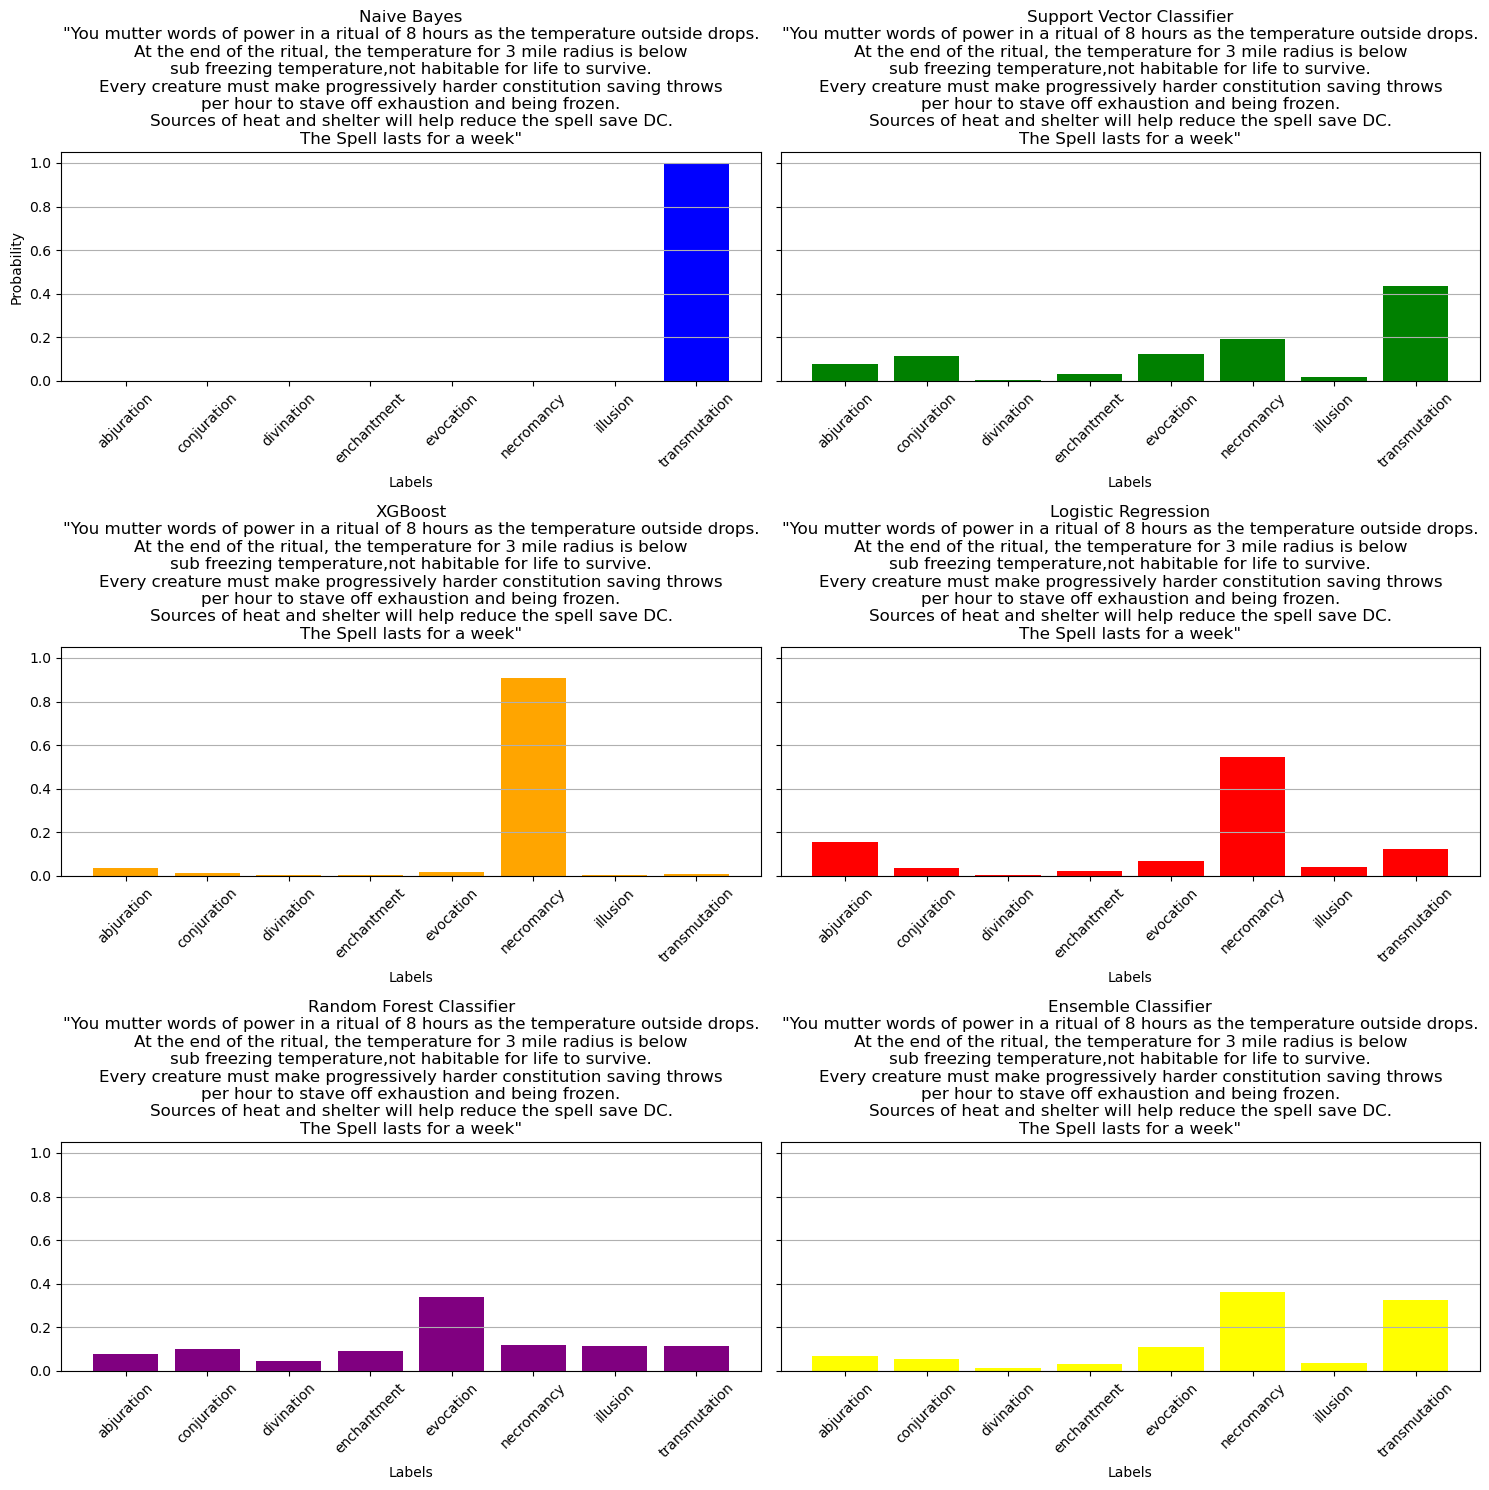

In [34]:
fake_spell = "You mutter words of power in a ritual of 8 hours as the temperature outside drops.\nAt the end of the ritual, the temperature for 3 mile radius is below\nsub freezing temperature,not habitable for life to survive.\nEvery creature must make progressively harder constitution saving throws\nper hour to stave off exhaustion and being frozen.\nSources of heat and shelter will help reduce the spell save DC.\nThe Spell lasts for a week"
probability_plots(fake_spell)

NB: Predicted: evocation 

XGB: Predicted: abjuration 

SVC: Predicted: evocation 

LR: Predicted: evocation 

RFC: Predicted: evocation 

Ensemble: Predicted: evocation 



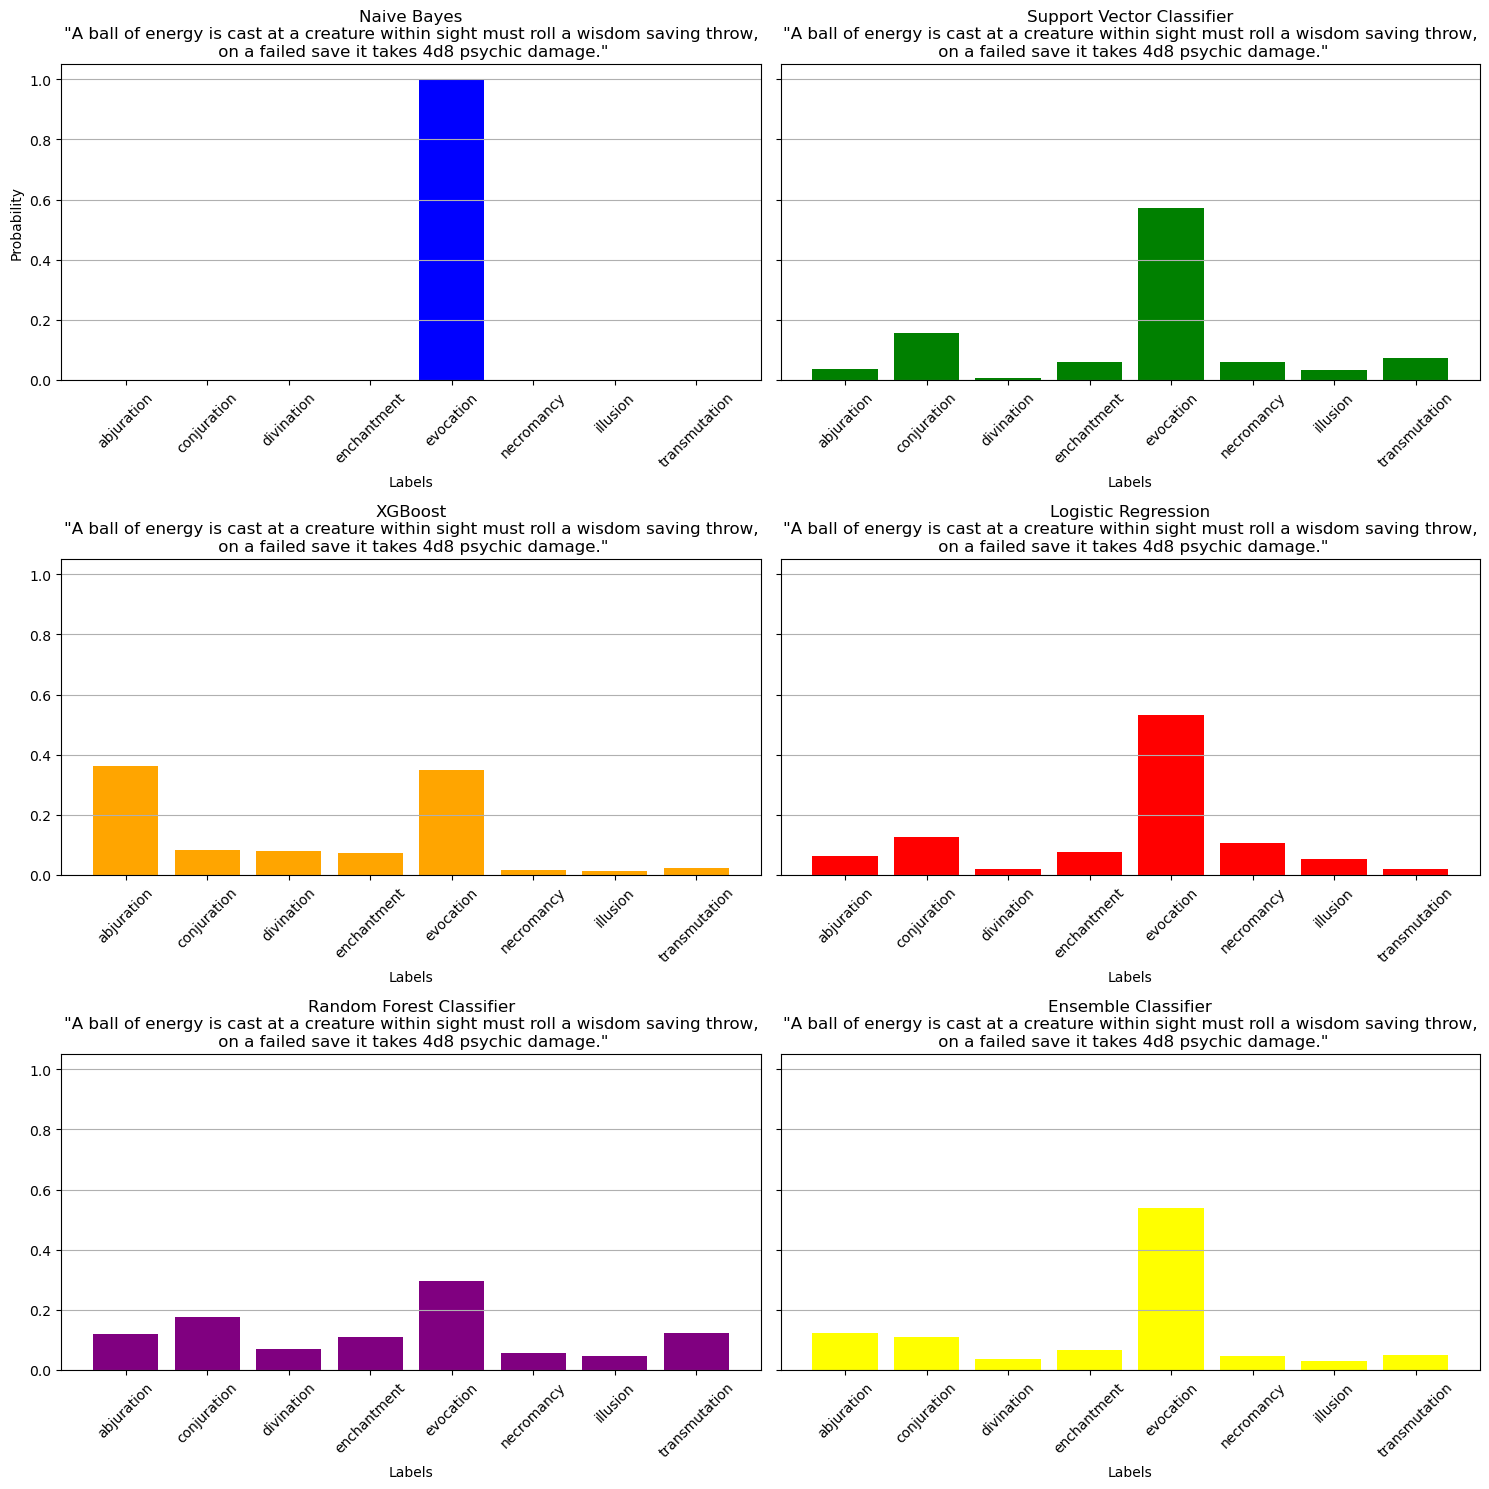

In [35]:
fake_spell = "A ball of energy is cast at a creature within sight must roll a wisdom saving throw,\n on a failed save it takes 4d8 psychic damage."
probability_plots(fake_spell)

NB: Predicted: enchantment 

XGB: Predicted: transmutation 

SVC: Predicted: necromancy 

LR: Predicted: necromancy 

RFC: Predicted: abjuration 

Ensemble: Predicted: enchantment 



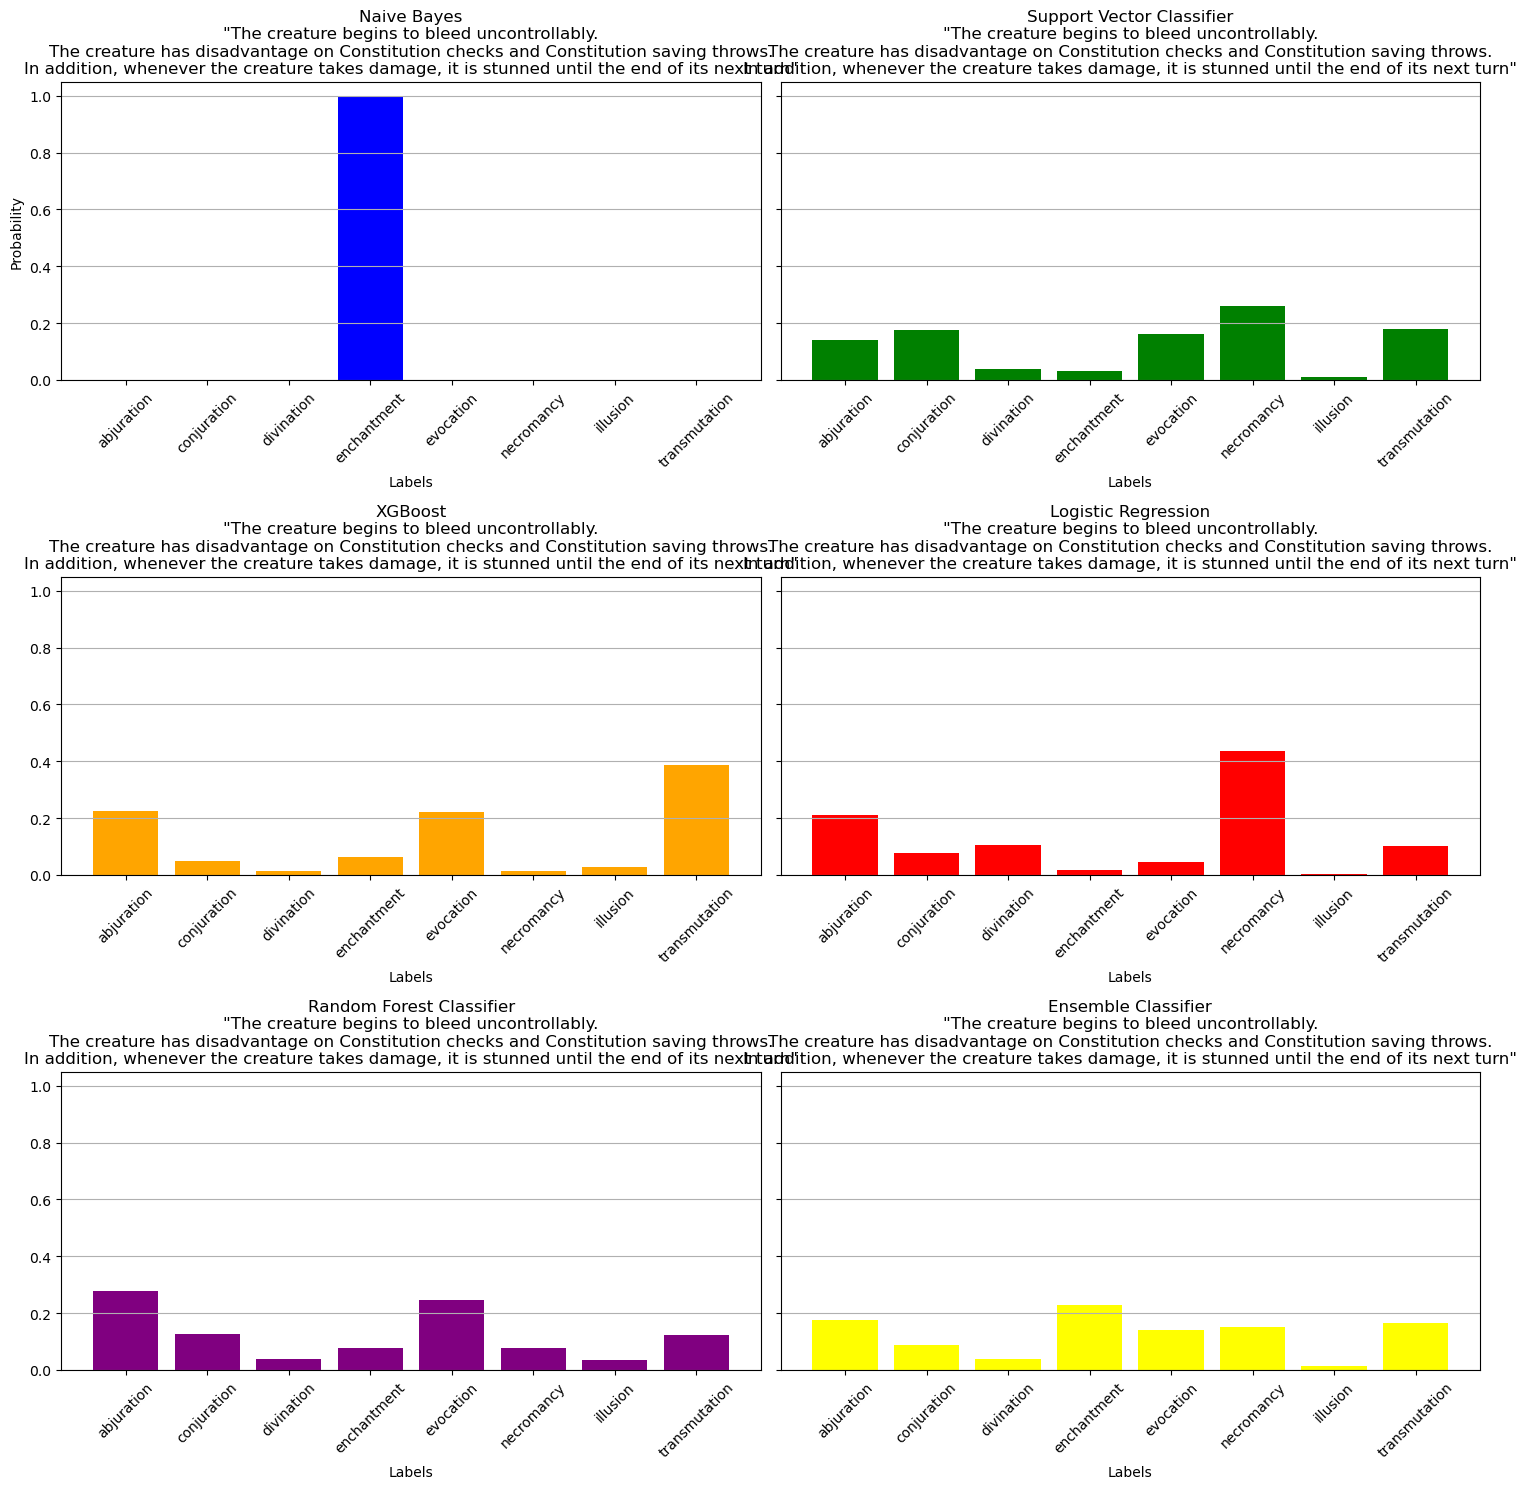

In [36]:
fake_spell = "The creature begins to bleed uncontrollably.\nThe creature has disadvantage on Constitution checks and Constitution saving throws.\nIn addition, whenever the creature takes damage, it is stunned until the end of its next turn"
probability_plots(fake_spell)

# 4.0 Significance
Let's see how actually useful this model is.
## 4.1 Confusion Matrix

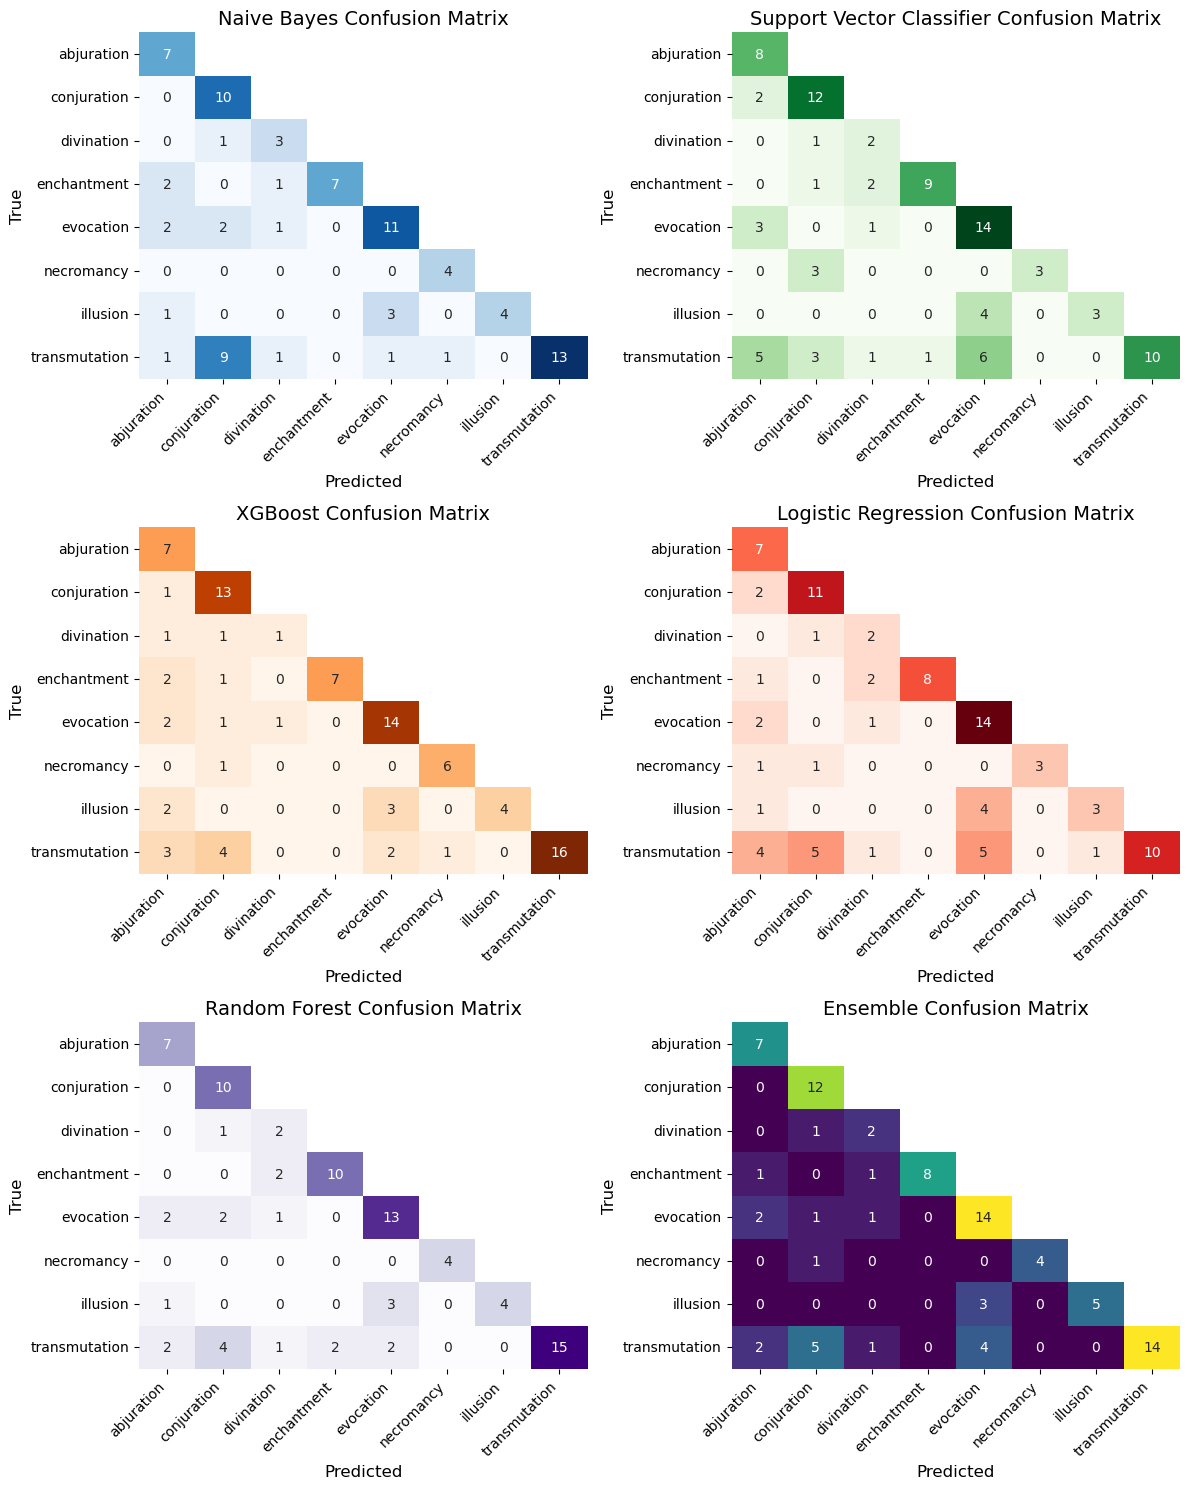

In [37]:
def plot_confusion_matrix(ax, y_true, y_pred, labels, title, map_cols):
    cm = confusion_matrix(y_true, y_pred)
    mask = np.triu(np.ones_like(cm, dtype=bool), k=1)
    sns.heatmap(cm, annot=True, fmt='d', cmap=map_cols, cbar=False, ax=ax, mask = mask)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xticks([0.5 + i for i in range(len(labels))])
    ax.set_yticks([0.5 + i for i in range(len(labels))])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)
    ax.set_title(title, fontsize=14)
    
# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Plot confusion matrix for Naive Bayes
plot_confusion_matrix(axes[0,0], y_test, pred_class_nb, labels, title='Naive Bayes Confusion Matrix', map_cols='Blues')

# Plot confusion matrix for XGBoost
plot_confusion_matrix(axes[1,0], y_test, pred_class_xgb, labels, title='XGBoost Confusion Matrix',  map_cols='Oranges')

# Plot confusion matrix for SVC
plot_confusion_matrix(axes[0,1], y_test, pred_class_svc, labels, title='Support Vector Classifier Confusion Matrix',  map_cols='Greens')

# Plot confusion matrix for LR
plot_confusion_matrix(axes[1,1], y_test, pred_class_lr, labels, title='Logistic Regression Confusion Matrix',  map_cols='Reds')

# Plot confusion matrix for RFC
plot_confusion_matrix(axes[2,0], y_test, pred_class_rf, labels, title='Random Forest Confusion Matrix',  map_cols='Purples')

# Plot confusion matrix for Ensemble
plot_confusion_matrix(axes[2,1], y_test, pred_class_ensemble, labels, title='Ensemble Confusion Matrix',  map_cols='viridis')

plt.tight_layout()
plt.show()

## 4.2 Recall, Precision and F1-Score

In [38]:
print(classification_report(y_test, pred_class_nb))

               precision    recall  f1-score   support

   abjuration       0.54      0.54      0.54        13
  conjuration       0.45      0.50      0.48        20
   divination       0.43      0.50      0.46         6
  enchantment       0.70      0.47      0.56        15
    evocation       0.44      0.58      0.50        19
     illusion       0.67      0.57      0.62         7
   necromancy       1.00      0.40      0.57        10
transmutation       0.45      0.50      0.47        26

     accuracy                           0.51       116
    macro avg       0.58      0.51      0.52       116
 weighted avg       0.55      0.51      0.51       116



In [39]:
print(classification_report(y_test, pred_class_xgb))

               precision    recall  f1-score   support

   abjuration       0.39      0.54      0.45        13
  conjuration       0.54      0.65      0.59        20
   divination       0.20      0.17      0.18         6
  enchantment       0.78      0.47      0.58        15
    evocation       0.56      0.74      0.64        19
     illusion       0.75      0.86      0.80         7
   necromancy       0.57      0.40      0.47        10
transmutation       0.80      0.62      0.70        26

     accuracy                           0.59       116
    macro avg       0.57      0.55      0.55       116
 weighted avg       0.61      0.59      0.59       116



In [40]:
print(classification_report(y_test, pred_class_svc))

               precision    recall  f1-score   support

   abjuration       0.44      0.62      0.52        13
  conjuration       0.57      0.60      0.59        20
   divination       0.22      0.33      0.27         6
  enchantment       0.75      0.60      0.67        15
    evocation       0.45      0.74      0.56        19
     illusion       1.00      0.43      0.60         7
   necromancy       1.00      0.30      0.46        10
transmutation       0.53      0.38      0.44        26

     accuracy                           0.53       116
    macro avg       0.62      0.50      0.51       116
 weighted avg       0.60      0.53      0.53       116



In [41]:
print(classification_report(y_test, pred_class_lr))

               precision    recall  f1-score   support

   abjuration       0.39      0.54      0.45        13
  conjuration       0.58      0.55      0.56        20
   divination       0.25      0.33      0.29         6
  enchantment       0.67      0.53      0.59        15
    evocation       0.45      0.74      0.56        19
     illusion       1.00      0.43      0.60         7
   necromancy       0.75      0.30      0.43        10
transmutation       0.48      0.38      0.43        26

     accuracy                           0.50       116
    macro avg       0.57      0.48      0.49       116
 weighted avg       0.55      0.50      0.50       116



In [42]:
print(classification_report(y_test, pred_class_rf))

               precision    recall  f1-score   support

   abjuration       0.58      0.54      0.56        13
  conjuration       0.56      0.50      0.53        20
   divination       0.22      0.33      0.27         6
  enchantment       0.62      0.67      0.65        15
    evocation       0.52      0.68      0.59        19
     illusion       1.00      0.57      0.73         7
   necromancy       0.80      0.40      0.53        10
transmutation       0.56      0.58      0.57        26

     accuracy                           0.56       116
    macro avg       0.61      0.53      0.55       116
 weighted avg       0.59      0.56      0.56       116



In [43]:
print(classification_report(y_test, pred_class_ensemble))

               precision    recall  f1-score   support

   abjuration       0.58      0.54      0.56        13
  conjuration       0.57      0.60      0.59        20
   divination       0.25      0.33      0.29         6
  enchantment       0.67      0.53      0.59        15
    evocation       0.48      0.74      0.58        19
     illusion       0.80      0.57      0.67         7
   necromancy       1.00      0.50      0.67        10
transmutation       0.58      0.54      0.56        26

     accuracy                           0.57       116
    macro avg       0.62      0.54      0.56       116
 weighted avg       0.61      0.57      0.57       116



# 5.0 Write to CSV
## 5.1 Write spells by Class
Let's write the spells into a CSV, sorted by each class.

In [44]:
# Additional padding to ensure classes with less spells don't 'clip' the rest of the csv
new_class_spell_group = {
    key: list(values) if isinstance(values, dict) else values
    for key, values in class_spell_group.items()
}

max_length = max(len(values) for values in new_class_spell_group.values())
new_class_spell_group = {
    key: values + [""] * (max_length - len(values))
    for key, values in new_class_spell_group.items()
}

with open("DND_Class_Spells.csv", "w", newline="") as f:
    # Use the keys of the dictionary as the column headers
    w = csv.DictWriter(f, fieldnames=new_class_spell_group.keys())
    w.writeheader()
    
    # Use zip to align rows across all columns
    rows = zip(*new_class_spell_group.values())
    for row in rows:
        # Create a dictionary for each row by zipping keys and values
        w.writerow(dict(zip(new_class_spell_group.keys(), row)))

# Conclusion
I didn't think I'd have much luck with the XGBoost but I thought *"why not, see what happens."*, and it wasn't actually that bad to be honest. So I'm quite pleased.

The naive bayes is poor, it's not a great metric but the 'fake spell' test is concerning how it kind of just **feels** as if the Naive Bayes is getting the sentiment more. It's evident as well even in the Recall and Precision. It is definitely worth binning this. Maybe it's worth seeing why, as the NLTK defaults to using Naive Bayes, has there been a study into this?

It's also clear that some feature importances or and some cross validation would maybe help push these accuracies up just a *little* more.

*I do also want to try some more data augmentation methods, I have read google translate really helps so interfacing with that could be brill*
